## <center>0. Project Definition

### AIM
To predict if a customer will subscribe to a bank deposit or not

### METHODOLOGY
1. Pre-processing the data and creating the final base table 
2. To further split the training data into train and validation
3. Hyper-parameter tuning
4. Model Evaluation 

## <center> 1. Libraries and Folders

In [115]:
Sys.setenv(LANG = "en")

# Data processing library
library(data.table)       # Data manipulation
library(dplyr)            # Data manipulation
library(plyr)             # Data manipulation
library(stringr)          # String, text processing
library(vita)             # Quickly check variable importance
library(dataPreparation)  # Data preparation library
library(woeBinning)       # Decision tree–based binning for numerical and categorical variables
library(Boruta)           # Variable selection
library(imbalance)
library(DescTools)
library(mefa4)            #for 'notin' operator

# Machine Learning Libraries
library(mlr)           # Machine learning framework
library(caret)         # Data processing and machine learning framework
library(MASS)          # LDA
library(randomForest)  # RF
library(gbm)           # Boosting Tree
library(xgboost)       # XGboost
library(kknn)          # K-Nearest Neighbours
library(ROCR)          # Performance Metrics

Warning message:
"package 'kknn' was built under R version 3.6.3"
Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy



<br>
<br>
<br>
<br>
<br>

## <center> 2. Creation of Base Table 

### 2.1 Importing the Datasets

In [93]:
# Read train (full), test (holdout)
data <- read.csv("C:/Users/bvarghese/Desktop/IESEG Slides/Statistical Learning- Minh Phan/In-class Kaggle Competition/data/Kaggle/input/bank_mkt_train.csv")  # Training dataset
predict <- read.csv("C:/Users/bvarghese/Desktop/IESEG Slides/Statistical Learning- Minh Phan/In-class Kaggle Competition/data/Kaggle/input/bank_mkt_test.csv") # Holdout data set without responsea

### 2.2 Inspecting the variables

In [27]:
# Print out to check the data type
str(data)

'data.frame':	7000 obs. of  21 variables:
 $ client_id     : int  2 3 4 5 6 7 8 9 14 15 ...
 $ age           : int  29 39 49 32 29 51 34 52 52 29 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 11 2 7 1 7 2 8 1 1 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 3 3 2 2 2 2 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 7 4 7 1 4 7 7 ...
 $ default       : Factor w/ 2 levels "no","unknown": 1 2 2 1 2 2 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 3 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 1 2 1 1 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 7 4 5 8 8 8 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 1 4 2 1 4 4 4 3 2 ...
 $ campaign      : int  3 6 2 3 2 1 1 1 3 1 ...
 $ pdays         : int  999 999 999 999 9

### 2.3 One-Hot Encoding for Categorical Variables

In [94]:
## Creating a list of the categorical variables

cat_list <- c()  # List to store categorical variable

for (v in colnames(data)) {
    if (class(data[, v]) == 'factor') {  # Factor == categorical variable
        cat_list <- c(cat_list, v)
    } 
}

## Loop through all categorical variables
for (v in cat_list) {
    
    # Representing categorical variable 
    encoding <- build_encoding(dataSet=data, cols=v, verbose=F)
    
    # Apply the binning for the training data
    data <- one_hot_encoder(dataSet=data, encoding=encoding, type='numeric', drop=T, verbose=F)
    setDF(data)
    data <- data[, -ncol(data)]  # Drop the last dummy column
    
    # Apply the binning for the prediction data
    predict <- one_hot_encoder(dataSet=predict, encoding=encoding, type='numeric', drop=T, verbose=F)
    setDF(predict)
    predict <- predict[, -ncol(predict)]  # Drop the last dummy column
    
}

### 2.4 Feature Engineering for Numeric Variables

#### 2.4.1 Correct the variable: campaign

Since campaign includes also the last contact, its value should be reduce by 1.

In [95]:
# Fix the value
data[, 'campaign'] <- data[, 'campaign'] - 1
predict[, 'campaign'] <- predict[, 'campaign'] - 1

# Quick check
min(data[, 'campaign'])  # Previously = 1
min(predict[, 'campaign'])  # Previously = 1

[1] 0

[1] 0

#### 2.4.2 Checking for outliers in numeric variables

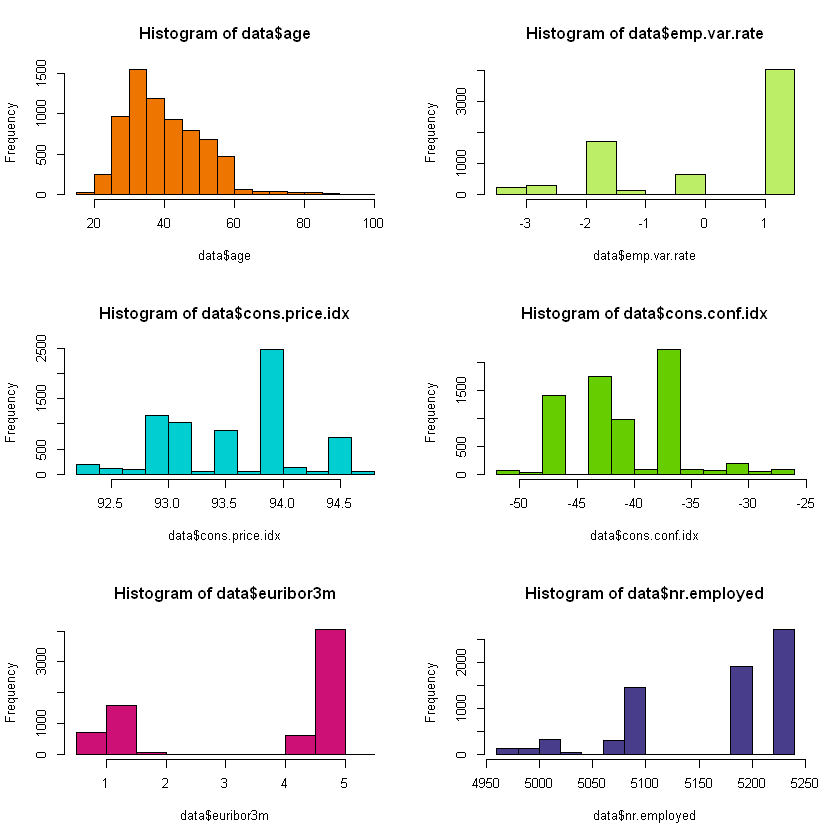

In [30]:
par(mfrow=c(3,2))
hist(data$age, col = "darkorange2")
hist(data$emp.var.rate, col= "darkolivegreen2")
hist(data$cons.price.idx, col= "darkturquoise")
hist(data$cons.conf.idx, col= "chartreuse3")
hist(data$euribor3m, col= "deeppink3")
hist(data$nr.employed, col= "darkslateblue")

#### 2.4.3 Splitting the data into train and test sets

In [96]:
# Splitting the data
set.seed(8)
smp_size <- floor(0.70*nrow(data))

# set the seed to make your partition reproducible
set.seed(8)
train_ind <- sample(seq_len(nrow(data)), size = smp_size)

train <- data[train_ind, ]
test <- data[-train_ind, ]

#### 2.4.4 Treating the abnormal distributions

In [97]:
train$age <- Winsorize(train$age, probs = c(0, 0.95))
test$age <- Winsorize(test$age, probs = c(0, 0.95))
predict$age <- Winsorize(predict$age, probs = c(0, 0.95))

#### 2.2.5 Checking for Imbalance in the Target Variable

In [33]:
round(prop.table(table(data$subscribe)), 2)


   0    1 
0.88 0.12 

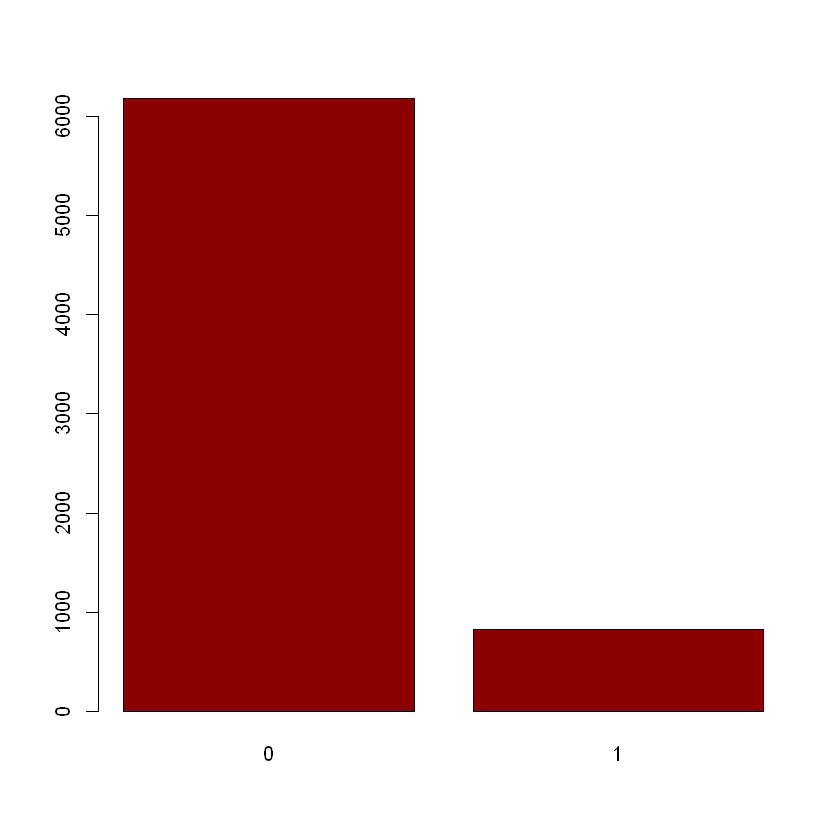

In [141]:
tbl <- with(data, table(subscribe))
barplot(tbl, beside = TRUE, col = "darkred")

#Oversampling is done while setting up the cross validation process

<br>
<br>
<br>
<br>
<br>

## <center> 3. Standardization

In [99]:
#Treating missing columns in the prediction set
dv_list <- c('subscribe')  # DV list
std_list <- setdiff(names(train), dv_list)  # IV list excluded DV

for (v in std_list){
    if (v %notin% names(predict)) {
        predict[,v] = 0
    } 
}

In [100]:
train_std <- train
test_std <- test 
predict_std <- predict

dv_list <- c('subscribe')  # DV list
std_list <- setdiff(names(train_std), dv_list)  # IV list excluded DV
std_list <- setdiff(std_list, 'client_id')  # Excluded the client_idb


for (v in std_list) {
    train_std[, v] <- scale(train_std[, v], center=T, scale=T)  # sd = 1, mean = 0
    test_std[, v] <- scale(test_std[, v], center=T, scale=T)  # sd = 1, mean = 0
    predict_std[, v] <- scale(predict_std[, v], center=T, scale=T)  # sd = 1, mean = 0
}

<br>
<br>
<br>
<br>
<br>

## <center> 4. Feature Selection

In [101]:
FisherScore <- function(basetable, depvar, IV_list) {
  
  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}

varSelectionFisher <- function(basetable, depvar, IV_list, num_select=20) {
  "
  This function will calculate the Fisher score for all IVs and select the best
  top IVs.

  Assumption: all variables of input dataset are converted into numeric type.
  "
  
  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

In [102]:
# Calculate Fisher Score for all variable
# Get the IV and DV list
dv_list <- c('subscribe')  # DV list
iv_list <- setdiff(names(train), dv_list)  # IV list excluded DV
iv_list <- setdiff(iv_list, 'client_id')  # Excluded the client_id
fs <- FisherScore(train, dv_list, iv_list)
head(fs)

IV,fisher_score
age,0.01142089
campaign,0.11588688
pdays,0.43319908
previous,0.36412613
emp.var.rate,0.65763389
cons.price.idx,0.28478531


In [103]:
# Select top 20 variables according to the Fisher Score
best_fs_var <- varSelectionFisher(train, dv_list, iv_list, num_select=20)
head(best_fs_var, 10)

[1] "nr.employed"          "euribor3m"            "emp.var.rate"        
 [4] "pdays"                "contact.cellular"     "previous"            
 [7] "poutcome.nonexistent" "cons.price.idx"       "month.may"           
[10] "month.oct"

In [104]:
# Apply variable selection to the data
# Train
var_select <- names(train)[names(train) %in% best_fs_var]
train_processed <- train[, c('client_id', var_select, 'subscribe')]
train_processed_std <- train_std[, c('client_id', var_select, 'subscribe')]  #standardised train set

# Test
var_select <- names(test)[names(test) %in% best_fs_var]
test_processed <- test[, c('client_id', var_select, 'subscribe')]
test_processed_std <- test_std[, c('client_id', var_select, 'subscribe')]    #standardised test set

# Predict
var_select <- names(test)[names(test) %in% best_fs_var]
predict_processed <- predict[, c('client_id', var_select)]
predict_processed_std <- predict_std[, c('client_id', var_select)]           #standardised prediction set

<br>
<br>
<br>
<br>
<br>

## <center> 4. Algorithms

#### 4.1 Logistic Regression

In [105]:
#Training the model and testing its performance
glm.fit = glm(subscribe~.,family=binomial(link='logit'),data=train_processed_std)
p_test <- predict(glm.fit, newdata=test_processed_std, type="response")

#Running the model on the Holdout Set
predicted.results = predict(glm.fit,newdata=predict_processed_std, type = "response")
predicted.results = data.frame(predicted.results)

In [106]:
#Evaluating the Performance of the Model 
pr <- prediction(p_test, test_processed$subscribe)
prf <- ROCR::performance(pr, measure = "tpr", x.measure = "fpr")
#plot(prf)

auc <- ROCR::performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.8101172

#### 4.2 Random Forest

In [56]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=5)

# Define the model
learner <- makeLearner("classif.randomForest", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
  makeDiscreteParam('ntree', value=c(100, 250, 500, 750, 1000)),
  makeDiscreteParam('mtry', value=round(sqrt((ncol(train_processed)-1) * c(0.1, 0.25, 0.5, 1, 2, 4))))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.randomForest for parameter set:
          Type len Def               Constr Req Tunable Trafo
ntree discrete   -   - 100,250,500,750,1000   -    TRUE     -
mtry  discrete   -   -          1,2,3,5,6,9   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: ntree=100; mtry=1
[Tune-y] 1: auc.test.mean=0.7393914; time: 0.0 min
[Tune-x] 2: ntree=250; mtry=1
[Tune-y] 2: auc.test.mean=0.7482690; time: 0.1 min
[Tune-x] 3: ntree=500; mtry=1
[Tune-y] 3: auc.test.mean=0.7508351; time: 0.1 min
[Tune-x] 4: ntree=750; mtry=1
[Tune-y] 4: auc.test.mean=0.7547151; time: 0.2 min
[Tune-x] 5: ntree=1000; mtry=1
[Tune-y] 5: auc.test.mean=0.7555304; time: 0.2 min
[Tune-x] 6: ntree=100; mtry=2
[Tune-y] 6: auc.test.mean=0.7629422; time: 0.0 min
[Tune-x] 7: ntree=250; mtry=2
[Tune-y] 7: auc.test.mean=0.7585109; time: 0.1 min
[Tune-x] 8: ntree=500; mtry=2
[Tune-y] 8: auc.test.mean=0.7641980; time: 0.2 min
[Tune-x] 9: ntree=750; mtry=2
[Tune-y]

In [64]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.7911403

#### 4.3 K-Nearest Neighbours

In [124]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.kknn", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeDiscreteParam('k', value=c(2:15))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.kknn for parameter set:
      Type len Def                            Constr Req Tunable Trafo
k discrete   -   - 2,3,4,5,6,7,8,9,10,11,12,13,14,15   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: k=2
[Tune-y] 1: auc.test.mean=0.6856570; time: 0.0 min
[Tune-x] 2: k=3
[Tune-y] 2: auc.test.mean=0.7061354; time: 0.0 min
[Tune-x] 3: k=4
[Tune-y] 3: auc.test.mean=0.7180844; time: 0.0 min
[Tune-x] 4: k=5
[Tune-y] 4: auc.test.mean=0.7274098; time: 0.0 min
[Tune-x] 5: k=6
[Tune-y] 5: auc.test.mean=0.7349128; time: 0.0 min
[Tune-x] 6: k=7
[Tune-y] 6: auc.test.mean=0.7402761; time: 0.0 min
[Tune-x] 7: k=8
[Tune-y] 7: auc.test.mean=0.7413902; time: 0.0 min
[Tune-x] 8: k=9
[Tune-y] 8: auc.test.mean=0.7448776; time: 0.0 min
[Tune-x] 9: k=10
[Tune-y] 9: auc.test.mean=0.7452591; time: 0.0 min
[Tune-x] 10: k=11
[Tune-y] 10: auc.test.mean=0.7494795; time: 0.0 min
[Tune-x] 11: k=12
[Tune-y] 11: auc.test.mean=0.7527436; time: 0.0

In [125]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.7422223

#### 4.4 LDA

In [127]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.lda", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7915663 
[Resample] iter 2:    0.8019344 
[Resample] iter 3:    0.7728774 
[Resample] iter 4:    0.8114542 
[Resample] iter 5:    0.8007002 
[Resample] iter 6:    0.7371684 
[Resample] iter 7:    0.7781523 
[Resample] iter 8:    0.7524611 
[Resample] iter 9:    0.7478682 
[Resample] iter 10:   0.7768932 


Aggregated Result: auc.test.mean=0.7771076




In [128]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.8012619

#### 4.5 QDA


In [130]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.qda", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7723700 
[Resample] iter 2:    0.7414267 
[Resample] iter 3:    0.7600418 
[Resample] iter 4:    0.7756753 
[Resample] iter 5:    0.7609568 
[Resample] iter 6:    0.7654842 
[Resample] iter 7:    0.7602867 
[Resample] iter 8:    0.7809415 
[Resample] iter 9:    0.8376484 
[Resample] iter 10:   0.7763439 


Aggregated Result: auc.test.mean=0.7731175




In [131]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.8029584

#### 4.6 XGBoost

In [134]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.xgboost", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    #makeDiscreteParam('max.depth', value=c(3, 4, 5, 6, 8, 10, 12, 15)),
    makeDiscreteParam('gamma', value=c(0.0, 0.1, 0.2 , 0.3, 0.4)),
    makeDiscreteParam('min_child_weight', value=c(1, 3, 5, 7))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.xgboost for parameter set:
                     Type len Def            Constr Req Tunable Trafo
gamma            discrete   -   - 0,0.1,0.2,0.3,0.4   -    TRUE     -
min_child_weight discrete   -   -           1,3,5,7   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: gamma=0; min_child_weight=1
[Tune-y] 1: auc.test.mean=0.7651838; time: 0.0 min
[Tune-x] 2: gamma=0.1; min_child_weight=1
[Tune-y] 2: auc.test.mean=0.7651640; time: 0.0 min
[Tune-x] 3: gamma=0.2; min_child_weight=1
[Tune-y] 3: auc.test.mean=0.7651671; time: 0.0 min
[Tune-x] 4: gamma=0.3; min_child_weight=1
[Tune-y] 4: auc.test.mean=0.7649555; time: 0.0 min
[Tune-x] 5: gamma=0.4; min_child_weight=1
[Tune-y] 5: auc.test.mean=0.7649835; time: 0.0 min
[Tune-x] 6: gamma=0; min_child_weight=3
[Tune-y] 6: auc.test.mean=0.7609404; time: 0.0 min
[Tune-x] 7: gamma=0.1; min_child_weight=3
[Tune-y] 7: auc.test.mean=0.7609034; time: 0.0 min
[Tune-x] 8: gamma=0.2

In [135]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.7836955

#### 4.7 SVM

In [139]:
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.svm", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=train_processed[, -1], target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    #makeDiscreteParam('max.depth', value=c(3, 4, 5, 6, 8, 10, 12, 15)),
    makeDiscreteParam('gamma', value=c(0.0:0.4)),
    makeDiscreteParam('cost', value=c(1:100))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
     par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.svm for parameter set:
          Type len Def                                   Constr Req Tunable
gamma discrete   -   -                                        0   -    TRUE
cost  discrete   -   - 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...   -    TRUE
      Trafo
gamma     -
cost      -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: gamma=0; cost=1
[Tune-y] 1: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 2: gamma=0; cost=2
[Tune-y] 2: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 3: gamma=0; cost=3
[Tune-y] 3: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 4: gamma=0; cost=4
[Tune-y] 4: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 5: gamma=0; cost=5
[Tune-y] 5: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 6: gamma=0; cost=6
[Tune-y] 6: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 7: gamma=0; cost=7
[Tune-y] 7: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 8: gamma=0; cost=8
[Tune-y] 8: auc.test.mean=0.5000000; 

[Tune-x] 97: gamma=0; cost=97
[Tune-y] 97: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 98: gamma=0; cost=98
[Tune-y] 98: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 99: gamma=0; cost=99
[Tune-y] 99: auc.test.mean=0.5000000; time: 0.2 min
[Tune-x] 100: gamma=0; cost=100
[Tune-y] 100: auc.test.mean=0.5000000; time: 0.2 min
[Tune] Result: gamma=0; cost=32 : auc.test.mean=0.5000000


In [140]:
# Retrain the model with tbe best hyper-parameters
best_md <- mlr::train(best_learner, train_task)

# Make prediction on valid data
pred <- predict(best_md, newdata=test_processed[, -1])
mlr::performance(pred, measures= mlr::auc)

auc 
0.7342109

In [ ]:
#Saving the predictions of the logistic regression model 
#write.csv(predicted.results ,"PredictionsToSubmit.csv", row.names = FALSE)